## Imports and Constants

In [1]:
import json
import os
import codecs
import pandas as pd
import matplotlib as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

import pickle


In [2]:
#constants
sample_rate = 2    #10 #frames per second

#butterworth lowpass filter (lowcut and high cut)
lc = 0.1 
hc = 0.2

#overlap - for one sliding window onto another
overlap = 0.25 #in percentage

## Start of Data processing

In [3]:
path=os.path.join('./young_data/testdata.txt')
with codecs.open(path, 'r', 'utf-8') as f:
    dataSet = json.load(f)
name=  ['tmag_x','tmag_y','tmag_z','tgyro_x','tgyro_y','tgyro_z','taccel_x','taccel_y','taccel_z','smag_x','smag_y','smag_z','sgyro_x','sgyro_y','sgyro_z','saccel_x','saccel_y','saccel_z','pose']
test=pd.DataFrame(columns=name, data=dataSet)
#test.to_csv('./testcsv.csv', encoding= 'gbk')

In [4]:
test

,tmag_x,tmag_y,tmag_z,tgyro_x,tgyro_y,tgyro_z,taccel_x,taccel_y,taccel_z,smag_x,smag_y,smag_z,sgyro_x,sgyro_y,sgyro_z,saccel_x,saccel_y,saccel_z,pose
0,-50.693,94.013,-241.052,66.803,3.838,24.567,-0.941,-0.13,-0.188,-76.263,167.151,62.641,25.65,0.786,12.627,-0.97,0.203,-0.162,1
1,-50.693,94.013,-241.052,66.803,3.838,24.567,-0.941,-0.13,-0.188,-75.561,167.151,62.91,-21.538,-1.427,-18.028,-0.87,0.29,-0.364,1
2,-50.274,94.297,-240.065,-32.898,-23.972,-10.033,-1.009,-0.08,0.13,-74.753,167.645,64.6,-12.65,-0.206,-3.288,-0.909,0.36,-0.167,1
3,-49.586,94.626,-237.553,-45.517,40.977,-3.822,-0.932,-0.212,-0.078,-75.336,167.869,65.527,-11.848,-3.12,4.005,-0.918,0.394,-0.001,1
4,-49.586,94.626,-237.553,-45.517,40.977,-3.822,-0.932,-0.212,-0.078,-77.819,167.495,65.168,-56.236,10.506,-13.451,-0.91,0.242,-0.256,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,-48.928,83.8,-188.984,5.28,17.662,2.716,-0.642,0.05,0.931,-37.863,170.008,129.214,-20.531,17.166,1.625,-0.872,-0.32,0.191,3
876,-48.928,83.8,-188.984,5.28,17.662,2.716,-0.642,0.05,0.931,-38.879,171.174,125.476,2.869,-0.87,2.96,-0.874,-0.354,0.276,3
877,-49.571,82.978,-187.862,25.528,-6.332,-0.71,-0.595,0.016,0.937,-40.315,172.266,121.902,-4.41,-0.42,1.991,-0.896,-0.311,0.229,3
878,-50.498,79.867,-184.109,14.732,-0.87,-8.743,-0.603,-0.055,0.927,-41.945,173.701,118.178,7.423,5.051,1.259,-0.862,-0.266,0.303,3


# Data processing

synchronization, noise filtering, and segmentation

In [6]:
test = test.astype(np.float64) #float

#removing mag
string = 'tgyro_x,tgyro_y,tgyro_z,taccel_x,taccel_y,taccel_z,sgyro_x,sgyro_y,sgyro_z,saccel_x,saccel_y,saccel_z,pose'
columns_to_keep = string.split(',')
#columns_to_keep

test = test[columns_to_keep]

## Combine data angles

In [7]:
#idea 1: find relative changes between the two sensortags
fn_x = lambda row: row.tgyro_x - row.sgyro_x # define a function for the new column
col = test.apply(fn_x, axis=1) # get column data with an index
test = test.assign(gyro_x = col.values) # assign values to column 'c'

fn_y = lambda row: row.tgyro_y - row.sgyro_y # define a function for the new column
col = test.apply(fn_y, axis=1) # get column data with an index
test = test.assign(gyro_y = col.values) # assign values to column 'c'

fn_z = lambda row: row.tgyro_z - row.sgyro_z # define a function for the new column
col = test.apply(fn_z, axis=1) # get column data with an index
test = test.assign(gyro_z = col.values) # assign values to column 'c'

fn_acc_x = lambda row: row.taccel_x - row.saccel_x # define a function for the new column
col = test.apply(fn_acc_x, axis=1) # get column data with an index
test = test.assign(acc_x = col.values) # assign values to column 'c'

fn_acc_y = lambda row: row.taccel_y - row.saccel_y # define a function for the new column
col = test.apply(fn_acc_y, axis=1) # get column data with an index
test = test.assign(acc_y = col.values) # assign values to column 'c'

fn_acc_z = lambda row: row.taccel_z - row.saccel_z # define a function for the new column
col = test.apply(fn_acc_z, axis=1) # get column data with an index
test = test.assign(acc_z = col.values) # assign values to column 'c'

In [8]:
#sample rate = 10hz = 0.1 seconds
test['time'] = test.index/sample_rate
test.head(10)

,tgyro_x,tgyro_y,tgyro_z,taccel_x,taccel_y,taccel_z,sgyro_x,sgyro_y,sgyro_z,saccel_x,saccel_y,saccel_z,pose,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,time
0,66.803,3.838,24.567,-0.941,-0.130,-0.188,25.650,0.786,12.627,-0.970,0.203,-0.162,1.0,41.153,3.052,11.940,0.029,-0.333,-0.026,0.0
1,66.803,3.838,24.567,-0.941,-0.130,-0.188,-21.538,-1.427,-18.028,-0.870,0.290,-0.364,1.0,88.341,5.265,42.595,-0.071,-0.420,0.176,0.5
2,-32.898,-23.972,-10.033,-1.009,-0.080,0.130,-12.650,-0.206,-3.288,-0.909,0.360,-0.167,1.0,-20.248,-23.766,-6.745,-0.100,-0.440,0.297,1.0
3,-45.517,40.977,-3.822,-0.932,-0.212,-0.078,-11.848,-3.120,4.005,-0.918,0.394,-0.001,1.0,-33.669,44.097,-7.827,-0.014,-0.606,-0.077,1.5
4,-45.517,40.977,-3.822,-0.932,-0.212,-0.078,-56.236,10.506,-13.451,-0.910,0.242,-0.256,1.0,10.719,30.471,9.629,-0.022,-0.454,0.178,2.0
5,-47.104,-65.636,-6.805,-0.898,-0.283,-0.131,-64.751,2.327,-20.866,-0.836,0.529,-0.087,1.0,17.647,-67.963,14.061,-0.062,-0.812,-0.044,2.5
6,-38.918,-43.419,-0.687,-0.876,-0.209,-0.186,-92.583,2.823,-32.646,-0.760,0.252,-0.206,1.0,53.665,-46.242,31.959,-0.116,-0.461,0.020,3.0
7,-38.918,-43.419,-0.687,-0.876,-0.209,-0.186,-11.269,11.993,7.118,-0.893,0.211,-0.419,1.0,-27.649,-55.412,-7.805,0.017,-0.420,0.233,3.5
8,37.971,-5.890,8.522,-0.934,-0.178,-0.140,7.576,-54.703,-21.797,-1.116,0.184,-0.219,1.0,30.395,48.813,30.319,0.182,-0.362,0.079,4.0
9,37.971,-5.890,8.522,-0.934,-0.178,-0.140,32.661,-4.967,-6.775,-0.978,-0.069,-0.291,1.0,5.310,-0.923,15.297,0.044,-0.109,0.151,4.5


In [9]:
# keep certain columns
string = 'pose,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,time'
keep = string.split(',')
test = test[keep]
test

,pose,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,time
0,1.0,41.153,3.052,11.940,0.029,-0.333,-0.026,0.0
1,1.0,88.341,5.265,42.595,-0.071,-0.420,0.176,0.5
2,1.0,-20.248,-23.766,-6.745,-0.100,-0.440,0.297,1.0
3,1.0,-33.669,44.097,-7.827,-0.014,-0.606,-0.077,1.5
4,1.0,10.719,30.471,9.629,-0.022,-0.454,0.178,2.0
...,...,...,...,...,...,...,...,...
875,3.0,25.811,0.496,1.091,0.230,0.370,0.740,437.5
876,3.0,2.411,18.532,-0.244,0.232,0.404,0.655,438.0
877,3.0,29.938,-5.912,-2.701,0.301,0.327,0.708,438.5
878,3.0,7.309,-5.921,-10.002,0.259,0.211,0.624,439.0


In [10]:
# reset all of the start times of each pose to 0.0

pose1 = test[test["pose"] == 1] 
pose2 = test[test["pose"] == 2] 
pose3 = test[test["pose"] == 3] 

for x in [pose1,pose2,pose3]:
    start = x['time'].iloc[0]
    x.loc[:, "time"] = x["time"].apply(lambda x: x - start)

C:\Users\Kinto\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


## Noise filtering

Raw data (Pose1 = standing, pose2 = squat, pose3 = bend)

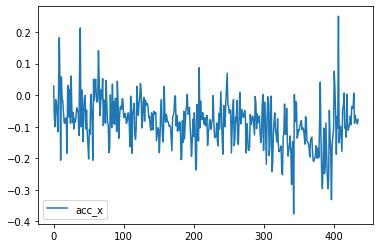

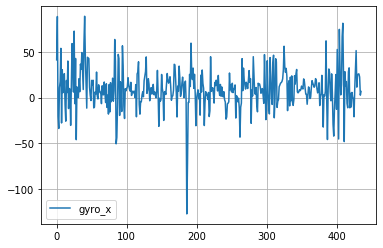

In [15]:
#visualising data
p = pose1
p.plot(use_index=True, y = "acc_x")
p.plot(use_index=True, y = "gyro_x", grid = True)

### Low passfilter - useful human motion usually lies below 10 Hz

In [76]:
#moving average filter
def moving_average(pose, N):

    A = 0
    B = A + (N * sample_rate) #sliding window length in seconds

    moving_avg = []
    for _ in range(B-A-1):
        moving_avg.append([0,0,0,0,0,0,])
    while (B <= len(pose)):

        #print(A, B)
        columns = pose.iloc[A:B][['gyro_x', 'gyro_y', 'gyro_z', 'acc_x', 'acc_y','acc_z']]
        mean_window = np.mean(columns.to_numpy(),axis = 0)

        
        moving_avg.append(mean_window)

        
        A += 1
        B = A + (N * sample_rate)
    
    return np.array(moving_avg)



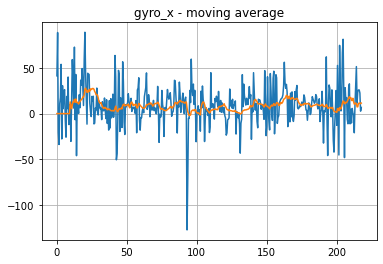

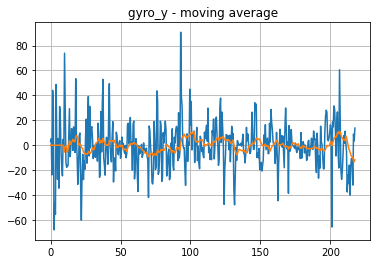

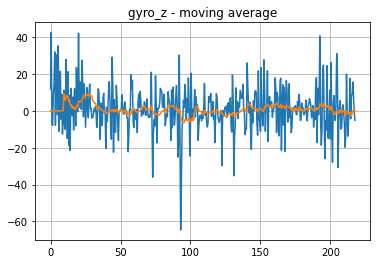

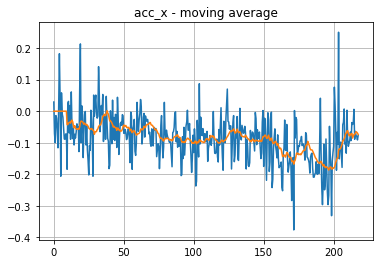

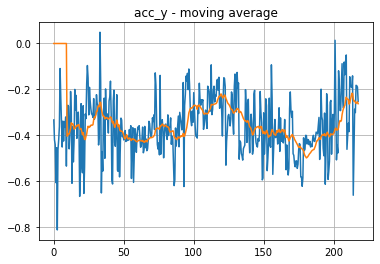

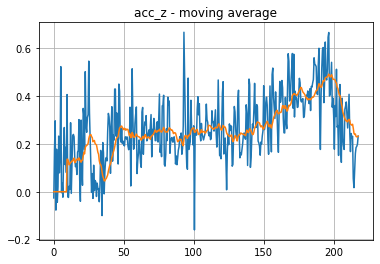

In [77]:
dic_measurements = {0: "gyro_x", 1: "gyro_y", 2: "gyro_z", 3: "acc_x", 4: "acc_y", 5: "acc_z"}
moving_array1 = moving_average(pose1,10)
moving_array2 = moving_average(pose2,10)
moving_array3 = moving_average(pose3,10)

for key,value in dic_measurements.items():
    filtered_pose1[value] = moving_array1[:,key]
    filtered_pose2[value] = moving_array2[:,key]
    filtered_pose3[value] = moving_array3[:,key]
    t = pose1[['time']]
    x = pose1[[value]]

    plt.figure()
    plt.title(value + " - moving average")
    plt.plot(t, x, label='Raw signal (%g Hz)')
    plt.grid()
    plt.plot(t, moving_array1[:,key], label='moving average signal (%g Hz)')

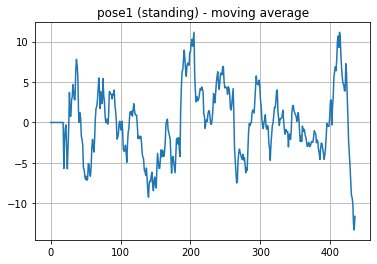

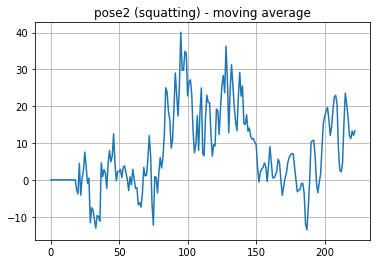

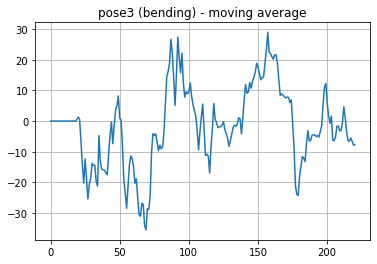

In [80]:
value = "gyro_y"

t1 = filtered_pose1.index
x1 = filtered_pose1[[value]]
t2 = filtered_pose2.index - filtered_pose2.index[0]
x2 = filtered_pose2[[value]]
t3 = filtered_pose3.index - filtered_pose3.index[0]
x3 = filtered_pose3[[value]]


plt.figure()
plt.grid()
plt.title("pose1 (standing) - moving average")
plt.plot(t1, x1, label='Raw signal (%g Hz)')

plt.figure()
plt.grid()
plt.title("pose2 (squatting) - moving average")
plt.plot(t2, x2, label='Raw signal (%g Hz)')

plt.figure()
plt.grid()
plt.title("pose3 (bending) - moving average")
plt.plot(t3, x3, label='Raw signal (%g Hz)')

In [83]:
# apply sliding windows with 50% overlapping and the size of 4 seconds
#(equivalent 512 samples at 128 Hz, see Section 5 later for the details) to segment strain signals,
#and reshaped the one dimensional time series data into a 16×32 = 512 sample two-dimensional matrix

def new_sliding_window_into_df(pose, N):

    A = 0
    B = A + (N * sample_rate) #sliding window length in seconds
    
    dataset = pd.DataFrame()
    while (B <= len(pose)):

        columns = pose.iloc[A:B][['gyro_x', 'gyro_y', 'gyro_z', 'acc_x', 'acc_y','acc_z']]
        array = columns.to_numpy().flatten()
        dataset = dataset.append({'pose' : pose['pose'].iloc[0], 'data' : [array]}, ignore_index = True)
        
        A += int(overlap * N * sample_rate)
        B = A + (N * sample_rate)
    
    return dataset

In [84]:
dataset_1 = new_sliding_window_into_df(filtered_pose1, 4)
dataset_2 = new_sliding_window_into_df(filtered_pose2, 4)
dataset_3 = new_sliding_window_into_df(filtered_pose3, 4)

/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel_2995/3409492725.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'pose' : pose['pose'].iloc[0], 'data' : [array]}, ignore_index = True)
/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel_2995/3409492725.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'pose' : pose['pose'].iloc[0], 'data' : [array]}, ignore_index = True)
/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel_2995/3409492725.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({'pose' : pose['pose'].iloc[0], 'data' : [array]}, ignore_index = True)
/var/folders/st/k8wwkd_s68g2vnl25tz040lh0000gn/T/ipykernel

In [86]:
combined_df = pd.concat([dataset_1, dataset_2, dataset_3])
combined_df.reset_index(drop= True, inplace = True)

# Perform SVM

In [89]:
print(combined_df.head(5))
Y = combined_df['pose']
x = combined_df['data']

   pose                                               data
0   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4   1.0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...


In [90]:
#randomise and split training/testing
import random
N = len(combined_df)

N_list = list(range(N))
random.shuffle(N_list)

training_list = N_list[:int(0.8 * N)]
testing_list = N_list[int(0.8 * N):]

print(training_list)
print(testing_list)


[50, 324, 137, 31, 387, 183, 359, 19, 412, 274, 11, 278, 266, 195, 327, 276, 24, 53, 149, 365, 27, 63, 308, 353, 361, 233, 340, 291, 267, 203, 245, 356, 400, 78, 106, 179, 64, 132, 244, 72, 306, 145, 262, 25, 38, 362, 360, 380, 226, 139, 315, 59, 242, 141, 175, 82, 219, 97, 44, 326, 309, 351, 333, 283, 236, 290, 8, 304, 30, 397, 403, 298, 394, 138, 128, 46, 42, 383, 3, 110, 206, 279, 136, 231, 328, 261, 406, 241, 61, 166, 159, 169, 124, 95, 48, 281, 419, 223, 54, 405, 79, 108, 122, 378, 277, 99, 311, 177, 292, 392, 316, 52, 131, 152, 371, 318, 1, 40, 126, 229, 77, 123, 386, 193, 127, 399, 89, 85, 5, 234, 214, 295, 426, 68, 161, 134, 12, 350, 254, 339, 341, 213, 146, 18, 401, 67, 197, 162, 384, 416, 358, 385, 181, 174, 96, 155, 143, 20, 320, 407, 251, 153, 133, 209, 225, 335, 173, 415, 98, 156, 135, 284, 250, 413, 289, 81, 74, 129, 212, 393, 288, 334, 147, 305, 14, 338, 80, 272, 43, 221, 282, 114, 422, 201, 377, 204, 260, 0, 321, 112, 151, 408, 414, 70, 100, 170, 417, 348, 314, 303, 117

In [91]:
training_dataset = combined_df.iloc[training_list]
testing_dataset = combined_df.iloc[testing_list]
training_dataset.head(5)

,pose,data
50,1.0,"[[8.796249999999999, -0.6829000000000008, 0.04..."
324,3.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
137,1.0,"[[5.091500000000001, -4.57225, 0.4852, -0.0761..."
31,1.0,"[[11.232699999999998, -3.66425, 4.720249999999..."
387,3.0,"[[21.37875, -5.5914, -8.037099999999999, 0.280..."


In [92]:
training_dataset = training_dataset.reset_index()
testing_dataset = testing_dataset.reset_index()

In [94]:
Y_train = training_dataset["pose"].to_list()
Y_test = testing_dataset["pose"].to_list()
x_train = [x[0] for x in training_dataset["data"].to_list()]
x_test = [x[0] for x in testing_dataset["data"].to_list()]
index_train = training_dataset["index"].to_list()
index_test = testing_dataset["index"].to_list()

for i in [Y_train, Y_test, x_train, x_test]:
    print(len(i))

344
86
344
86


In [96]:
def generate_results(model, xTrain, yTrain, xTest, yTest):
    num_dec_point = 3
    #train_flag = True

    # generate predictions
    y_pred = model.predict(xTest)
    y_train_pred = model.predict(xTrain) 
    print('Model Training accuracy is: ', accuracy_score(yTrain, y_train_pred))

    # calculate testing accuracy
    accuracy = accuracy_score(yTest, y_pred)
    print('Model Testing accuracy is: ', accuracy)

    p_mic, r_mic, f1_mic, _ = precision_recall_fscore_support(yTest, 
                            y_pred,
                            average='micro',
                            warn_for=())
    p_mac, r_mac, f1_mac, _ = precision_recall_fscore_support(yTest, 
                        y_pred,
                        average='macro',
                        warn_for=())
    print('micro acc,prec,rec,f1: ',round(accuracy,num_dec_point), round(p_mic,num_dec_point), round(r_mic,num_dec_point), round(f1_mic,num_dec_point),sep="\t")
    print('macro prec,rec,f1: ',round(p_mac,num_dec_point), round(r_mac,num_dec_point), round(f1_mac,num_dec_point),sep="\t")
    print('Confusion Matrix is:\n', confusion_matrix(yTest, y_pred))

In [97]:
model = SVC(kernel='linear')
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.9709302325581395
Model Testing accuracy is:  0.8604651162790697
micro acc,prec,rec,f1: 	0.86	0.86	0.86	0.86
macro prec,rec,f1: 	0.91	0.825	0.851
Confusion Matrix is:
 [[42  0  0]
 [ 9 15  0]
 [ 2  1 17]]


In [98]:
model = SVC(kernel='rbf', C = 1, probability = True, gamma = 'scale')
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.8372093023255814
Model Testing accuracy is:  0.7325581395348837
micro acc,prec,rec,f1: 	0.733	0.733	0.733	0.733
macro prec,rec,f1: 	0.763	0.656	0.678
Confusion Matrix is:
 [[41  0  1]
 [10 13  1]
 [ 7  4  9]]


In [99]:
model = SVC(kernel='poly', degree = 6, C = 1, probability = True, gamma = 'scale')
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.8343023255813954
Model Testing accuracy is:  0.686046511627907
micro acc,prec,rec,f1: 	0.686	0.686	0.686	0.686
macro prec,rec,f1: 	0.751	0.603	0.618
Confusion Matrix is:
 [[41  0  1]
 [13  8  3]
 [ 9  1 10]]


In [100]:
model = tree.DecisionTreeClassifier()
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.9767441860465116
Model Testing accuracy is:  0.8604651162790697
micro acc,prec,rec,f1: 	0.86	0.86	0.86	0.86
macro prec,rec,f1: 	0.866	0.84	0.846
Confusion Matrix is:
 [[40  2  0]
 [ 5 16  3]
 [ 2  0 18]]


In [101]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_train,Y_train)
generate_results(model, x_train, Y_train, x_test, Y_test)

Model Training accuracy is:  0.8459302325581395
Model Testing accuracy is:  0.7093023255813954
micro acc,prec,rec,f1: 	0.709	0.709	0.709	0.709
macro prec,rec,f1: 	0.762	0.642	0.649
Confusion Matrix is:
 [[40  0  2]
 [ 8  9  7]
 [ 8  0 12]]


=========

In [120]:
#saving the trained model

filename = 'SVM.sav'
pickle.dump(model, open(filename, 'wb'))

In [121]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(x_test, Y_test)
#print(result)